Federico Sanna

CID : 01063509

Deep Learning

**Some guidelines on how to run the code**

The notebook can be scrolled sequentially and the relevant models/parameters can be selected as you compile.

- The first section is simply routine of loading the repo and importing all the necessary files and libraries;
- In the model section it is possible to select the models for the denoiser and the descriptor. Note that for brevity not every single structure tested has been reported as used exactly, but some lines of code can be commented/uncommented to obtain all the relevant models. As an example, for the descriptor the LRN layers can be added by following the indications given in the comments directing the user on what to comment/uncomment;
- Training of the denoiser: here the final parameter used are left, but also other implementation are present in the code and not exacuted. These can be included by for example calling a different optimizer in the training section;
- Training of the descriptor: depending on the training purpose different sets of patches were used (noisy, denoised, clean) and different paramenters included into the triplet loss function. These can be changed as suggested by the comments in the code and contain now the final implementation;
- Tasks execution: the performance of the model can be tested on the execution of the tasks.




# Baseline and Improved Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [0]:
# Change directory
%cd /content/keras_triplet_descriptor    


In [0]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [0]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [0]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Cropping2D
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
from google.colab import files

The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


The following lines allow to make sure that we can create a Keras layer correcly. Here is a small harness I adapted from the Keras source to run the layer against some input and return a result:

In [0]:
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape

def test_layer(layer, x):
  layer_config = layer.get_config()
  layer_config["input_shape"] = x.shape
  layer = layer.__class__.from_config(layer_config)
  model = Sequential()
  model.add(layer)
  model.compile("rmsprop", "mse")
  x_ = np.expand_dims(x, axis=0)
  return model.predict(x_)[0]

And here are some tests with layer objects provided by Keras to make sure that the harness runs okay:

In [0]:
from keras.layers.core import Dropout, Reshape
from keras.layers.convolutional import ZeroPadding2D

import numpy as np
x = np.random.randn(10, 10)
layer = Dropout(0.5)
y = test_layer(layer, x)
assert(x.shape == y.shape)
x = np.random.randn(10, 10, 3)
layer = ZeroPadding2D(padding=(1,1))
y = test_layer(layer, x)
assert(x.shape[0] + 2 == y.shape[0])
assert(x.shape[1] + 2 == y.shape[1])
x = np.random.randn(10, 10)
layer = Reshape((5, 20))
y = test_layer(layer, x)
assert(y.shape == (5, 20))

You can test this layer during development using the test harness we described here. It is easier to run this instead of trying to build a whole network to put this into, or worse, waiting till you have fully specified the layer before running it:

In [0]:
x = np.random.randn(225, 225, 3)
layer = LRN()
y = test_layer(layer, x)
assert(x.shape == y.shape)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

**Baseline**

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture''' 
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  #Local Response Normalization layer
#   descriptor_model.add(LocalResponseNormalization())
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(LocalResponseNormalization(alpha=256,k=0,beta=0.5,n=256)) # Try with LRN
  
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

**LRN implementation**

For the descriptor it will need useful later to have a layer that you can simply insert. Here it is implemented a version of the LRN to stuck it at the end of the L2-Net.

In [0]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec

class LocalResponseNormalization(Layer):
  def __init__(self, n=5, alpha=0.0005, beta=0.75, k=2, **kwargs):
    self.n = n
    self.alpha = alpha
    self.beta = beta
    self.k = k
    super(LocalResponseNormalization, self).__init__(**kwargs)
    
    def build(self, input_shape):
      print('Input shape:', input_shape)
      self.shape = input_shape
      super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x, mask=None):
      if K.image_dim_ordering == "th":
        _, f, r, c = self.shape
      else:
        _, r, c, f = self.shape
      squared = K.square(x)
      pooled = K.pool2d(squared, (n, n), strides=(1, 1),
      padding="same", pool_mode="avg")
      if K.image_dim_ordering == "th":
        summed = K.sum(pooled, axis=1, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=1)
      else:
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
      denom = K.pow(self.k + averaged, self.beta)
      print('Print x over denom ', (x / denom))
      return x / denom

    def get_output_shape_for(self, input_shape):
      return input_shape

In [0]:
def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture''' 
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  #Local Response Normalization layer
#   descriptor_model.add(LocalResponseNormalization())
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(LocalResponseNormalization(alpha=256,k=0,beta=0.5,n=256)) # Try with LRN
  
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
print(descriptor_model.summary())

def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1) 

**CS L2-net**

The CS L2.-Net has been developed starting from the basic L2-Net architecture. A cropping 4,4 layer and a reshapng layer have been applied in oder to generate the input to the second tower.

Ideas for alternative implementation here: 
- https://github.com/virtualgraham/L2-Net-Python-Keras/blob/master/src/L2_Net.py
- https://github.com/computervisionlearner/L2-Net-TensorFlow/blob/master/model.py

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net

#Descriptor model implemented as CS L2-Net
def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  inputs = Input(shape)
  
  #Implementing the LEFT tower
  
  #descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  #descriptor_model.add(BatchNormalization(axis = -1))
  #descriptor_model.add(Activation('relu'))
  left_conv1 = Conv2D(32, 3, activation = 'relu', padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(inputs)
  left_norm1 = BatchNormalization(axis = -1)(left_conv1)

#   descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
#   descriptor_model.add(BatchNormalization(axis = -1))
#   descriptor_model.add(Activation('relu'))
  left_conv2 = Conv2D(32, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(left_norm1)
  left_norm2 = BatchNormalization(axis = -1)(left_conv2)

#   descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
#   descriptor_model.add(BatchNormalization(axis = -1))
#   descriptor_model.add(Activation('relu'))
  left_conv3 = Conv2D(64, 3, activation = 'relu', padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(left_norm2)
  left_norm3 = BatchNormalization(axis = -1)(left_conv3)

#   descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
#   descriptor_model.add(BatchNormalization(axis = -1))
#   descriptor_model.add(Activation('relu'))
  left_conv4 = Conv2D(64, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(left_norm3)
  left_norm4 = BatchNormalization(axis = -1)(left_conv4)

#   descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
#   descriptor_model.add(BatchNormalization(axis = -1))
#   descriptor_model.add(Activation('relu'))
  left_conv5 = Conv2D(128, 3, activation = 'relu', padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(left_norm4)
  left_norm5 = BatchNormalization(axis = -1)(left_conv5)

#   descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
#   descriptor_model.add(BatchNormalization(axis = -1))
#   descriptor_model.add(Activation('relu'))
#   descriptor_model.add(Dropout(0.3))
  left_conv6 = Conv2D(128, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(left_norm5)
  left_norm6 = BatchNormalization(axis = -1)(left_conv6)
  left_drop6 = Dropout(0.3)(left_norm6)

#   descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  left_conv7 = Conv2D(128, 8, activation = 'relu', padding='valid', use_bias = True, kernel_initializer=init_weights)(left_drop6)
  
  # Uncomment the following if want LRN
#   left_norm7 = BatchNormalizationn(axis = -1)(left_conv7)
#   left_lrn8 = LRN(alpha=256,k=0,beta=0.5,n=256, kernel_initializer=init_weights)(left_norm7)
  
  # Final descriptor reshape
  left_resh8 = Reshape((128,))(left_conv7)
  
  
  #Implementing the RIGHT tower
  
  crop0 = Cropping2D(cropping=((4, 4), (4, 4)))(inputs)
  zoom0 = Lambda(lambda image: K.tf.image.resize_images(image, (32, 32)))(crop0)
  
  right_conv1 = Conv2D(32, 3, activation = 'relu', padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(zoom0)
  right_norm1 = BatchNormalization(axis = -1)(right_conv1)

  right_conv2 = Conv2D(32, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(right_norm1)
  right_norm2 = BatchNormalization(axis = -1)(right_conv2)

  right_conv3 = Conv2D(64, 3, activation = 'relu', padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(right_norm2)
  right_norm3 = BatchNormalization(axis = -1)(right_conv3)

  right_conv4 = Conv2D(64, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(right_norm3)
  right_norm4 = BatchNormalization(axis = -1)(right_conv4)

  right_conv5 = Conv2D(128, 3, activation = 'relu', padding='same', strides=2, use_bias = True, kernel_initializer=init_weights)(right_norm4)
  right_norm5 = BatchNormalization(axis = -1)(right_conv5)

  right_conv6 = Conv2D(128, 3, activation = 'relu', padding='same', use_bias = True, kernel_initializer=init_weights)(right_norm5)
  right_norm6 = BatchNormalization(axis = -1)(right_conv6)
  right_drop6 = Dropout(0.3)(right_norm6)
  
  right_conv7 = Conv2D(128, 8, activation = 'relu', padding='valid', use_bias = True, kernel_initializer=init_weights)(right_drop6)
  
    # Uncomment the following if want LRN
#   right_norm7 = BatchNormalizationn(axis = -1)(right_conv7)
#   right_lrn8 = LRN(alpha=256,k=0,beta=0.5,n=256, kernel_initializer=init_weights)(right_norm7)
  
  # Final descriptor reshape
  right_resh8 = Reshape((128,))(right_conv7)
  
  # Concatenating towers' output
  merge = concatenate([left_resh8,right_resh8], axis = -1)
  # Uncomment the following if want LRN
#   merge = concatenate([left_lrn8,right_lrn8], axis = -1)
  
  descriptor_model = Model(inputs = inputs, outputs = merge)
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


**Testing different paramenters for the training of the descriptor and for its loss function (triplet loss)**

Many different parameters to calculate the loss function have been tried in order to check if the tuning of any of these could have resulted in better results.

In particular:

- different distance metrics have been tried;
- different values of alfa (used in the triplet loss function) have been used;
- different optimizers have been tested;
- different activation function have been tested.

None of them resulted in better performance than the baseline.

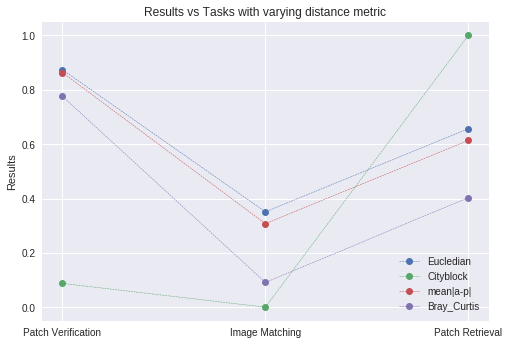

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Uncomment the desired section to obtain the plot wanted

baseline = [0.714930, 0.104292, 0.358950]
baseline = [0.833973, 0.236848, 0.533769]
noisy = [0.841033, 0.270181, 0.534195]


Eucledian = [0.873758, 0.351474, 0.656642]
mean_abs = [0.863187, 0.307753, 0.614272]
Cityblock = [0.088392, 0.000921, 1.000000]
Bray_Curtis = [0.775844, 0.091840, 0.403752]

plt.plot(np.arange(1,4), Eucledian, 'o--', np.arange(1,4),  Cityblock, 'o--' , np.arange(1,4), mean_abs, 'o--', np.arange(1,4), Bray_Curtis, 'o--', linewidth=0.5)
plt.ylabel('Results')
#plt.xlabel('Tasks')
plt.xticks(np.arange(1,4),('Patch Verification', 'Image Matching', 'Patch Retrieval'))
plt.title('Results vs Tasks with varying distance metric')
plt.legend(['Eucledian','Cityblock', 'mean|a-p|', 'Bray_Curtis'])
plt.show()


SGD = [0.873758, 0.351474, 0.656642]
Adam = [0.866783, 0.323154, 0.626965]
Adagard = [0.450660, 0.018097, 0.063855]
Adadelta = [0.857027, 0.309144, 0.612269]

# plt.plot(np.arange(1,4), SGD, 'o--', np.arange(1,4), Adam, 'o--', np.arange(1,4), Adagard, 'o--', np.arange(1,4), Adadelta, 'o--', linewidth=0.5)
# plt.ylabel('Results')
# #plt.xlabel('Tasks')
# plt.xticks(np.arange(1,4),('Patch Verification', 'Image Matching', 'Patch Retrieval'))
# plt.title('Results vs Tasks with varying optimizers')
# plt.legend(['SGD','Adam', 'Adagard','Adadelta'])
# plt.show()

Relu = [0.873758, 0.351474, 0.656642]
LeakyRelu = [0.864173, 0.343846, 0.633189]
Sigmoid = [0.818332, 0.285230, 0.565913]

# plt.plot(np.arange(1,4), Relu, 'o--', np.arange(1,4), LeakyRelu, 'o--', np.arange(1,4), Sigmoid, 'o--', linewidth=0.5)
# plt.ylabel('Results')
# #plt.xlabel('Tasks')
# plt.xticks(np.arange(1,4),('Patch Verification', 'Image Matching', 'Patch Retrieval'))
# plt.title('Results vs Tasks with varying activation function')
# plt.legend(['Relu','LeakyRelu', 'Sigmoid'])
# plt.show()


alpha_02 = [0.477504,  0.058475, 0.226133]
alpha_09 = [0.865728, 0.326662, 0.634152 ]
alpha_1 = [0.873758, 0.351474, 0.656642]
alpha_1_2 = [0.863807, 0.327841, 0.635850]
alpha_2 = [0.858450, 0.318959, 0.637294]
alpha_5 = [0.857721, 0.319731, 0.629530]


# plt.plot(np.arange(1,4), alpha_02, 'o--', np.arange(1,4), alpha_09, 'o--', np.arange(1,4), alpha_1, 'o--', np.arange(1,4), alpha_1_2, 'o--', np.arange(1,4), alpha_2, 'o--', np.arange(1,4), alpha_5, 'o--',linewidth=0.5)
# plt.ylabel('Results')
# #plt.xlabel('Tasks')
# plt.xticks(np.arange(1,4),('Patch Verification', 'Image Matching', 'Patch Retrieval'))
# plt.title('Results vs Tasks with varying alpha')
# plt.legend(['0.2','0.9', '1','1.2', '2', '5'] )
# plt.show()

##Implementing different structures for the denoiser##


**Ful U-Net**

As evaluated in figure 3.

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv4= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv6= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
  
  conv7= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv8= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  # Bottleneck
  conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  # Now the decoder starts
  up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  merge1 = concatenate([conv8,up1], axis = -1)
  conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  up2 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv12))
  merge2 = concatenate([conv6,up2], axis = -1)
  conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  conv14 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv14))
  merge3 = concatenate([conv4,up3], axis = -1)
  conv15 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv2,up4], axis = -1)
  conv17 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net

**Shallow Full UNet (one less "flor of convolution")**


In [0]:
def get_denoise_model(shape):
  
  inputs = Input(shape)
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#   conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#   drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
#   up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#   merge6 = concatenate([drop4,up6], axis = 3)
#   conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

# UNet_model().summary()

**Shallower Thick U-Net**

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3= Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv4= Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv6= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  #pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
  
  #conv7= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  #conv8= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  ## Bottleneck
  #conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  #conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  ## Now the decoder starts
  #up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  #merge1 = concatenate([conv8,up1], axis = -1)
  #conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  #conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  #up2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv12))
  #merge2 = concatenate([conv6,up2], axis = -1)
  #conv13 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  #conv14 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge3 = concatenate([conv4,up3], axis = -1)
  conv15 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv2,up4], axis = -1)
  conv17 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net


modellino = get_denoise_model((32, 32, 1))  
print(modellino.summary())

**Shallow Thin U-Net**

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv4= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv6= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
  
  conv7= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv8= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  ## Bottleneck
  #conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  #conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  ## Now the decoder starts
  #up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  #merge1 = concatenate([conv8,up1], axis = -1)
  #conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  #conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  up2 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge2 = concatenate([conv6,up2], axis = -1)
  conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  conv14 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv14))
  merge3 = concatenate([conv4,up3], axis = -1)
  conv15 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv2,up4], axis = -1)
  conv17 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net

**Shallower U-Unet**

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv4= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5= Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv6= Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  #pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
  
  #conv7= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  #conv8= Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  ## Bottleneck
  #conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  #conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  ## Now the decoder starts
  #up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  #merge1 = concatenate([conv8,up1], axis = -1)
  #conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  #conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  #up2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv12))
  #merge2 = concatenate([conv6,up2], axis = -1)
  #conv13 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  #conv14 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge3 = concatenate([conv4,up3], axis = -1)
  conv15 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv2,up4], axis = -1)
  conv17 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net


modellino = get_denoise_model((32, 32, 1))  
print(modellino.summary())

**Shallow Thin Truncated U-Net**

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  #conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv3= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  #conv4= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv5= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  #conv6= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)
  
  conv7= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  #conv8= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  ## Bottleneck
  #conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  #conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  ## Now the decoder starts
  #up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  #merge1 = concatenate([conv8,up1], axis = -1)
  #conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  #conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  up2 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge2 = concatenate([conv5,up2], axis = -1)
  conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  conv14 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv14))
  merge3 = concatenate([conv3,up3], axis = -1)
  conv15 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv1,up4], axis = -1)
  conv17 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net

**Final implementation of the Denoiser**

***Shallow Thin U-Net***


In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv4= Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)   
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
  
  conv5= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv6= Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
  
  conv7= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv8= Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  #pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
  
  ## Bottleneck
  #conv9 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  #conv10 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

  ## Now the decoder starts
  #up1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
  #merge1 = concatenate([conv8,up1], axis = -1)
  #conv11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  #conv12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
  
  up2 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge2 = concatenate([conv6,up2], axis = -1)
  conv13 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  conv14 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv13)
  
  up3 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv14))
  merge3 = concatenate([conv4,up3], axis = -1)
  conv15 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv16 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv15)
  
  up4 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv16))
  merge4 = concatenate([conv2,up4], axis = -1)
  conv17 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv18 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv17)
  
  conv19 = Conv2D(1, 3,  padding = 'same')(conv18) ####different

  U_net = Model(inputs = inputs, outputs = conv19)
  
  return U_net

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MSE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [0]:
# denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
# denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:42<00:00,  1.08s/it]


In [0]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

In [0]:
# Use to import a downloaded model

from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
### FIRST DENOISER
### If you have a model saved from a previous training session load it in here
denoise_model = keras.models.load_model('./denoise.h5')

In [0]:
### SECOND DESCRIPTOR
### If you have a model saved from a previous training session load it in the next line
descriptor_model = keras.models.load_model('./descriptor.h5')

We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [0]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
adag = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
denoise_model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
epochs = 25
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
acc_denoise_history = []
val_acc_denoise_history = []
for e in range(epochs):
  print("Epoch is "+ str(e))
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val)
  ### Saves optimizer and weights
  denoise_model.save('denoise.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@denoise.h5" https://file.io
  # list all data in history
  print(denoise_history.history.keys())
  acc_denoise_history.append(denoise_history.history['loss'][0])
  val_acc_denoise_history.append(denoise_history.history['val_loss'][0])
  print("Length of acc_descriptor_history is:"+str(len(acc_denoise_history)))
  print(acc_denoise_history)
  print("Length of val_acc_descriptor_history is:"+str(len(val_acc_denoise_history)))
  print(val_acc_denoise_history)
    

# summarize history for accuracy
plt.plot(acc_denoise_history)
plt.plot(val_acc_denoise_history)
plt.title('denoiser loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# Print the vectors of interest
print(acc_denoise_history)
print(len(acc_denoise_history))
print(val_acc_denoise_history)
print(len(val_acc_denoise_history))


Epoch is 0
Epoch 1/1
31179/31179 [==============================] - 1346s 43ms/step - loss: 4.7690 - mean_absolute_error: 4.7690 - val_loss: 4.8053 - val_mean_absolute_error: 4.8053
{"success":true,"key":"IAsUY2","link":"https://file.io/IAsUY2","expiry":"14 days"}['val_mean_absolute_error', 'loss', 'mean_absolute_error', 'val_loss']
Length of acc_descriptor_history is:1
[4.769031520368366]
Length of val_acc_descriptor_history is:1
[4.805322320592685]
Epoch is 1
Epoch 1/1
31179/31179 [==============================] - 1346s 43ms/step - loss: 4.7439 - mean_absolute_error: 4.7439 - val_loss: 4.6982 - val_mean_absolute_error: 4.6982
{"success":true,"key":"G4K3HE","link":"https://file.io/G4K3HE","expiry":"14 days"}['val_mean_absolute_error', 'loss', 'mean_absolute_error', 'val_loss']
Length of acc_descriptor_history is:2
[4.769031520368366, 4.743905371624631]
Length of val_acc_descriptor_history is:2
[4.805322320592685, 4.698177648779601]
Epoch is 2
Epoch 1/1
31179/31179 [==================

KeyboardInterrupt: ignored

The data are saved in csv format to be saved on an excel document for better clarity and comparison.

In [0]:
# Save the arrays as csv files on drive
np.savetxt("acc_denoise_history_Full_UNet_Dani_minusOne_LessFilters_Adam_FULL.csv", acc_denoise_history, delimiter=",")
np.savetxt("val_acc_denoise_history_Full_UNet_Dani_minusOne_LessFilters_Adam_FULL.csv", val_acc_denoise_history, delimiter=",")
# Download the csv files to local
files.download('acc_denoise_history_Full_UNet_Dani_minusOne_LessFilters_Adam_FULL.csv') 
files.download('val_acc_denoise_history_Full_UNet_Dani_minusOne_LessFilters_Adam_FULL.csv') 

Here's the results from the last model compared to the baseline. Reported here to be plotted.

In [0]:
acc_denoise_history = [5.214467089639343, 4.84271375805454, 4.784877683480229, 4.769031520368366, 4.743905371624631, 4.73130940691312, 4.727267280177494, 4.719721058547571, 4.717515143594479, 4.720769112868468, 4.713865061117345, 4.708594343776122, 4.76719458234169, 4.728815107334264, 4.712262374441208, 4.723720566235924]
val_acc_denoise_history = [4.832710056417571, 4.755009008442636, 4.732028707268983, 4.805322320592685, 4.698177648779601, 4.720364766546434, 4.694518374946174, 4.699053158810132, 4.693863155710416, 4.69863545018544, 4.6695240982936745, 4.683012382514834, 4.705646548609096, 4.739514794312124, 4.696200637517013, 4.6651829072872175] 



In [0]:
acc_denoise_history_b= [6.605758154811667, 6.107506895207537, 5.97812004547244, 5.902694707440001, 5.84530550782288, 5.799913249399217, 5.761958014846915, 5.728362844319061, 5.699180528670172, 5.675832882216232, 5.652930247010955, 5.6341564465128835, 5.616560115521796, 5.60021057278477, 5.586067033940394, 5.573189682955769]
val_acc_denoise_history_b = [6.0026497707967685, 5.840012688699357, 5.9603648282098645, 5.885064849277807, 5.675170275645619, 5.67407635180656, 5.616647733578219, 5.591053912095197, 5.568778335841622, 5.585632338761657, 5.59265116741651, 5.524075437831128, 5.510696283200281, 5.686354662927743, 5.486624982488437, 5.476781755632616]

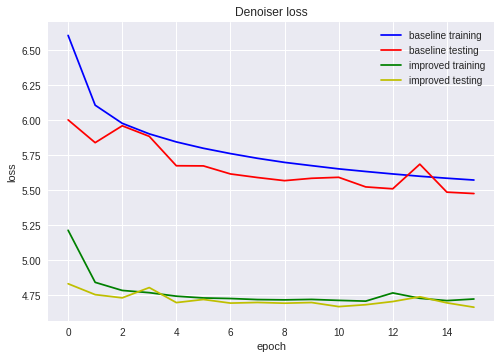

[5.214467089639343, 4.84271375805454, 4.784877683480229, 4.769031520368366, 4.743905371624631, 4.73130940691312, 4.727267280177494, 4.719721058547571, 4.717515143594479, 4.720769112868468, 4.713865061117345, 4.708594343776122, 4.76719458234169, 4.728815107334264, 4.712262374441208, 4.723720566235924]
16
[4.832710056417571, 4.755009008442636, 4.732028707268983, 4.805322320592685, 4.698177648779601, 4.720364766546434, 4.694518374946174, 4.699053158810132, 4.693863155710416, 4.69863545018544, 4.6695240982936745, 4.683012382514834, 4.705646548609096, 4.739514794312124, 4.696200637517013, 4.6651829072872175]
16


In [0]:
# Plot of the results
plt.plot(range(16), acc_denoise_history_b, 'b-', label='baseline training')
plt.plot(range(16), val_acc_denoise_history_b, 'r-', label='baseline testing')
plt.plot(range(16), acc_denoise_history, 'g-', label='improved training')
plt.plot(range(16), val_acc_denoise_history, 'y-', label='improved testing')
plt.legend(loc='best')

plt.title('Denoiser loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['baseline training', 'baseline testing','improved training', 'improved testing'], loc='upper left')
plt.show()

print(acc_denoise_history)
print(len(acc_denoise_history))
print(val_acc_denoise_history)
print(len(val_acc_denoise_history))


After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

In [0]:
# Use to import a downloaded model

from google.colab import files
files.upload()

In [0]:
### If you have a model saved from a previous training session
### Load it in the next line
denoise_model = keras.models.load_model('./descriptor.h5')

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [0]:
from google.colab import files
files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


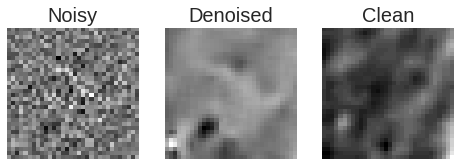

In [0]:
plot_denoise(denoise_model)

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)


Using clean patches
100%|██████████| 116/116 [00:34<00:00,  3.40it/s]


100%|██████████| 100000/100000 [00:01<00:00, 66855.42it/s]


Using clean patches
100%|██████████| 116/116 [00:20<00:00,  5.61it/s]


100%|██████████| 10000/10000 [00:00<00:00, 59674.47it/s]


*Trying things*

[1475, 3469, 5463, 7457, 9451, 11445, 13439, 15433, 17427, 19421, 21415, 23409, 25403, 27397, 29391, 31385]


16

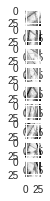

In [0]:
# Trying to understand how to build a matrix of euclidean distances in batches of anchor-positive pairs in order to modify the loss function
# x, y = hPatches.read_image_file(hpatches_dir, train=1) 
# type(x)
# x.shape
# len(y)

# plt.imshow(x[1])
# plt.imshow(x[1475])
# plt.imshow(x[5463])
# y[5463]
# y[1475]
# ottengo in x le immagini dei patches e in y ottengo i labels.
# Posso poi utilizzarli per creare le coppie ordinate myself, oppure posso 
indices = [i for i, m in enumerate(y) if m == 1475]
print(indices)
# for j in range(len(indices)-3):
#   plt.subplot(2,1,1)
#   plt.imshow(x[indices[j]])
#   plt.subplot(2,1,2)
#   plt.imshow(x[indices[j+1]])
#   plt.subplot(2,1,3)
#   plt.imshow(x[indices[j+2]])
j= 7
plt.subplot(16,1,1)
plt.imshow(x[indices[j]])
plt.subplot(16,1,2)
plt.imshow(x[indices[j+1]])
plt.subplot(16,1,3)
plt.imshow(x[indices[j+2]])
plt.subplot(16,1,4)
plt.imshow(x[indices[j+3]])
plt.subplot(16,1,5)
plt.imshow(x[indices[j+4]])
plt.subplot(16,1,6)
plt.imshow(x[indices[j+5]])
plt.subplot(16,1,7)
plt.imshow(x[indices[j+6]])
plt.subplot(16,1,8)
plt.imshow(x[indices[j+7]])
plt.subplot(16,1,9)
plt.imshow(x[indices[j+8]])
len(indices)

We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

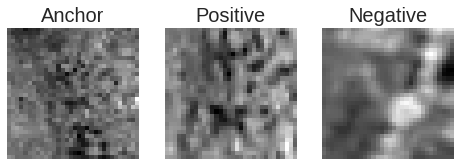

In [0]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [0]:
epochs = 25
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
### If you have a model saved from a previous training session
### Load it in the next line
#  descriptor_model_trip = keras.models.load_model('./descriptor.h5')
acc_descriptor_history = []
val_acc_descriptor_history = []
for e in range(epochs):
  print("Epoch is "+ str(e))
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  ### Saves optimizer and weights
  print("Saving the optimizer and weights\n")
  descriptor_model_trip.save('descriptor.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@descriptor.h5" https://file.io
  # descriptor_model_trip.save_weights('descriptor.h5') 
  # list all data in history
  print("Data stored in history are:")
  print(descriptor_history.history.keys())
  acc_descriptor_history.append(descriptor_history.history['loss'][0])
  val_acc_descriptor_history.append(descriptor_history.history['val_loss'][0])
  print("Length of acc_descriptor_history is:"+str(len(acc_descriptor_history)))
  print(acc_descriptor_history)
  print("Length of val_acc_descriptor_history is:"+str(len(val_acc_descriptor_history)))
  print(val_acc_descriptor_history)
  

# summarize history for accuracy
plt.plot(acc_descriptor_history)
plt.plot(val_acc_descriptor_history)
plt.title('descriptor loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Print the vectors of interest
print(acc_descriptor_history)
print(len(acc_descriptor_history))
print(val_acc_descriptor_history)
print(len(val_acc_descriptor_history))
 

Epoch is 0
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2024

100%|██████████| 100000/100000 [00:03<00:00, 32275.30it/s]


2000/2000 [==============================] - 184s 92ms/step - loss: 0.2024 - val_loss: 0.2023
Saving the optimizer and weights

{"success":true,"key":"CUTHlJ","link":"https://file.io/CUTHlJ","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:1
[0.20237004244700074]
Length of val_acc_descriptor_history is:1
[0.2023040408268571]
Epoch is 1
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1333

100%|██████████| 100000/100000 [00:03<00:00, 27379.52it/s]


2000/2000 [==============================] - 171s 85ms/step - loss: 0.1333 - val_loss: 0.1620


100%|██████████| 10000/10000 [00:00<00:00, 59763.24it/s]


Saving the optimizer and weights

{"success":true,"key":"4rEnIs","link":"https://file.io/4rEnIs","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:2
[0.20237004244700074, 0.13332603710098193]
Length of val_acc_descriptor_history is:2
[0.2023040408268571, 0.16196399386972188]
Epoch is 2
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1142

100%|██████████| 100000/100000 [00:05<00:00, 18674.92it/s]


2000/2000 [==============================] - 173s 87ms/step - loss: 0.1142 - val_loss: 0.1582
Saving the optimizer and weights

{"success":true,"key":"RQ1krC","link":"https://file.io/RQ1krC","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:3
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851]
Length of val_acc_descriptor_history is:3
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663]
Epoch is 3
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1022

100%|██████████| 100000/100000 [00:03<00:00, 27084.30it/s]


2000/2000 [==============================] - 171s 85ms/step - loss: 0.1022 - val_loss: 0.1976


100%|██████████| 10000/10000 [00:00<00:00, 58252.60it/s]


Saving the optimizer and weights

{"success":true,"key":"HYV4HR","link":"https://file.io/HYV4HR","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:4
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851, 0.10223155769344885]
Length of val_acc_descriptor_history is:4
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663, 0.1976313801202923]
Epoch is 4
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0960

100%|██████████| 100000/100000 [00:03<00:00, 28164.11it/s]


2000/2000 [==============================] - 171s 85ms/step - loss: 0.0960 - val_loss: 0.1164
Saving the optimizer and weights

{"success":true,"key":"GlsMdj","link":"https://file.io/GlsMdj","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:5
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851, 0.10223155769344885, 0.09596728499460733]
Length of val_acc_descriptor_history is:5
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663, 0.1976313801202923, 0.11641649689525366]
Epoch is 5
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0890

100%|██████████| 100000/100000 [00:03<00:00, 26692.47it/s]


2000/2000 [==============================] - 171s 85ms/step - loss: 0.0890 - val_loss: 0.1401
Saving the optimizer and weights

{"success":true,"key":"r8FtX0","link":"https://file.io/r8FtX0","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:6
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851, 0.10223155769344885, 0.09596728499460733, 0.08899605207836431]
Length of val_acc_descriptor_history is:6
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663, 0.1976313801202923, 0.11641649689525366, 0.1401247924368363]
Epoch is 6
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0854

100%|██████████| 100000/100000 [00:03<00:00, 26550.51it/s]


2000/2000 [==============================] - 170s 85ms/step - loss: 0.0854 - val_loss: 0.1365


100%|██████████| 10000/10000 [00:00<00:00, 60933.61it/s]


Saving the optimizer and weights

{"success":true,"key":"vHqfCh","link":"https://file.io/vHqfCh","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:7
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851, 0.10223155769344885, 0.09596728499460733, 0.08899605207836431, 0.08535107620003692]
Length of val_acc_descriptor_history is:7
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663, 0.1976313801202923, 0.11641649689525366, 0.1401247924368363, 0.13647883026860655]
Epoch is 7
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0828

100%|██████████| 100000/100000 [00:03<00:00, 25576.04it/s]


2000/2000 [==============================] - 173s 86ms/step - loss: 0.0828 - val_loss: 0.1353


100%|██████████| 10000/10000 [00:00<00:00, 60291.40it/s]


Saving the optimizer and weights

{"success":true,"key":"jyLD8X","link":"https://file.io/jyLD8X","expiry":"14 days"}Data stored in history are:
['loss', 'val_loss']
Length of acc_descriptor_history is:8
[0.20237004244700074, 0.13332603710098193, 0.11420628600769851, 0.10223155769344885, 0.09596728499460733, 0.08899605207836431, 0.08535107620003692, 0.08280499492374656]
Length of val_acc_descriptor_history is:8
[0.2023040408268571, 0.16196399386972188, 0.15823523320257663, 0.1976313801202923, 0.11641649689525366, 0.1401247924368363, 0.13647883026860655, 0.1353197330608964]
Epoch is 8
Epoch 1/1
1657/2000 [=======================>......] - ETA: 28s - loss: 0.0777

Save the results in csv format in order to store them in an excel doc.

In [0]:
# Save the arrays as csv files on drive
np.savetxt("acc_descriptor_history_LRN.csv", acc_descriptor_history, delimiter=",")
np.savetxt("val_acc_descriptor_history_LRN.csv", val_acc_descriptor_history, delimiter=",")
# Download the csv files to local
files.download('acc_descriptor_history_LRN.csv') 
files.download('val_acc_descriptor_history_LRN.csv')

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [0]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████| 40/40 [06:31<00:00, 11.68s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:33<00:00, 10702.47it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:31<00:00, 10931.50it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:31<00:00, 10907.95it/s]
>> Verification task finished in 285 secs  
Verification task results:
Mean Average Precision is 0.465830




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:11<00:00,  4.47s/it]
>> Matching task finished in 132 secs  
Matching task results:
Mean Average Precision is 0.050430






### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x55fa630ee000 @  0x7f035d9b01e7 0x7f03535b1cf1 0x7f03536143a2 0x7f03536160de 0x7f03536ad0e8 0x55fa3cb23fe5 0x55fa3cb19d0a 0x55fa3cb215fe 0x55fa3cb21232 0x55fa3cb19d0a 0x55fa3cb21c38 0x55fa3cb19d0a 0x55fa3cb19629 0x55fa3cb4a61f 0x55fa3cb45322 0x55fa3cb4467d 0x55fa3caf31ab 0x7f035d5adb97 0x55fa3caf2a2a


## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

File ID: 1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8


{u'id': u'1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8'}